# ЛР №1. Процесс построения адекватной модели. Визуализация кривых остатков

In [1]:
from sklearn.datasets import fetch_california_housing

X = fetch_california_housing()['data']
y = fetch_california_housing()['target']
X, y

(array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]], shape=(20640, 8)),
 array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,)))

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(16512, 8)

Было выбрано разделение выборки 80/20 для того, чтобы было больше строк данных для обучения.

Проверим данные на линейность

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [4]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(k=1)
skb_x = skb.fit_transform(X, y)

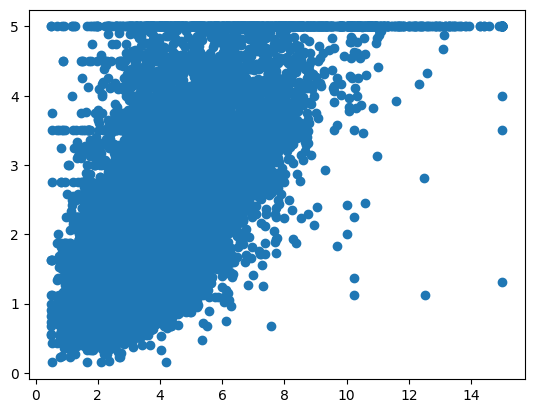

In [5]:
from matplotlib import pyplot as plt

plt.scatter(skb_x, y)

Заметна линейная зависимость от наиболее значимого признака. Предположительно, хорошо должна справится модель линейной регрессии. Также попробуем DecisionTreeRegressor и GradientBoostingRegressor.

In [6]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def gen_objective(estimator_class, grid, X_train, y_train, **kwargs):
    def objective(trial):
        params = {}
        for k, v in grid.items():
            if v[0] == 'cat':
                params[k] = trial.suggest_categorical(k, v[1])
            elif v[0] == 'int':
                params[k] = trial.suggest_int(k, *v[1])
            elif v[0] == 'float':
                params[k] = trial.suggest_float(k, *v[1], log=True)
      
        regressor = estimator_class(**params)
    
        mse_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error') 
        return -mse_scores.mean()

    return objective

def get_best_params(X, y, model, params):
    my_objective = gen_objective(model, params, X, y)
    study = optuna.create_study(direction="minimize")
    study.optimize(my_objective, n_trials=50)
    return study.best_params

d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_metrics(model_name, y_test, y_pred):
    print(model_name)
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'R2: {r2_score(y_test, y_pred)}')

In [8]:
lr = LinearRegression(**get_best_params(X_train, y_train, LinearRegression, 
                                        {
                                            'fit_intercept': ('cat', [True, False]),
                                            'copy_X': ('cat', [True, False]),
                                        }))
lr.fit(X_train, y_train)
y_pr = lr.predict(X_test)
get_metrics('Linear Regression', y_test, y_pr)

[I 2025-09-10 22:30:04,287] A new study created in memory with name: no-name-054b5bff-42ea-4ed9-8b31-0f7940233882
[I 2025-09-10 22:30:04,323] Trial 0 finished with value: 0.5523667639165346 and parameters: {'fit_intercept': True, 'copy_X': True}. Best is trial 0 with value: 0.5523667639165346.
[I 2025-09-10 22:30:04,337] Trial 1 finished with value: 0.641127390331452 and parameters: {'fit_intercept': False, 'copy_X': False}. Best is trial 0 with value: 0.5523667639165346.
[I 2025-09-10 22:30:04,354] Trial 2 finished with value: 0.5523667639165346 and parameters: {'fit_intercept': True, 'copy_X': False}. Best is trial 0 with value: 0.5523667639165346.
[I 2025-09-10 22:30:04,372] Trial 3 finished with value: 0.5523667639165346 and parameters: {'fit_intercept': True, 'copy_X': True}. Best is trial 0 with value: 0.5523667639165346.
[I 2025-09-10 22:30:04,389] Trial 4 finished with value: 0.641127390331452 and parameters: {'fit_intercept': False, 'copy_X': True}. Best is trial 0 with value:

Linear Regression
MSE: 0.5214417566155557
MAE: 0.5292713646482188
R2: 0.5874703759545634


In [9]:
from sklearn.linear_model import Ridge

ridge = Ridge(**get_best_params(X_train, y_train, Ridge, 
                                        {
                                            'alpha': ('float', [0.00001, 10]),
                                            'solver': ('cat', ['svd', 'cholesky', 'lsqr']),
                                        }))
ridge.fit(X_train, y_train)
y_pr = ridge.predict(X_test)
get_metrics('Ridge', y_test, y_pr)

[I 2025-09-10 22:30:05,197] A new study created in memory with name: no-name-964c2c79-bc8d-4967-8e60-97f124b6dc58
[I 2025-09-10 22:30:05,225] Trial 0 finished with value: 0.5523654996747593 and parameters: {'alpha': 0.04843288599374805, 'solver': 'cholesky'}. Best is trial 0 with value: 0.5523654996747593.
[I 2025-09-10 22:30:05,253] Trial 1 finished with value: 0.5523667215314549 and parameters: {'alpha': 0.0016231919238498353, 'solver': 'svd'}. Best is trial 0 with value: 0.5523654996747593.
[I 2025-09-10 22:30:05,282] Trial 2 finished with value: 0.5562813885623605 and parameters: {'alpha': 8.149775373433513, 'solver': 'lsqr'}. Best is trial 0 with value: 0.5523654996747593.
[I 2025-09-10 22:30:05,292] Trial 3 finished with value: 0.5523667621761039 and parameters: {'alpha': 6.665128729597656e-05, 'solver': 'cholesky'}. Best is trial 0 with value: 0.5523654996747593.
[I 2025-09-10 22:30:05,323] Trial 4 finished with value: 0.55627339499804 and parameters: {'alpha': 0.000222599519835

Ridge
MSE: 0.521689511863029
MAE: 0.52938882800564
R2: 0.5872743686770512


In [10]:
from sklearn.linear_model import Lasso

lasso = Lasso(**get_best_params(X_train, y_train, Lasso, 
                                        {
                                            'alpha': ('float', [0.00001, 10]),
                                            'selection': ('cat', ['cyclic', 'random']),
                                            'warm_start': ('cat', [True, False]),
                                        }))
lasso.fit(X_train, y_train)
y_pr = lasso.predict(X_test)
get_metrics('Lasso', y_test, y_pr)

[I 2025-09-10 22:30:06,537] A new study created in memory with name: no-name-4b0b7bd9-8320-4645-81b3-cd46dd13fd16
[I 2025-09-10 22:30:07,064] Trial 0 finished with value: 0.5512279088806025 and parameters: {'alpha': 0.005507390218841124, 'selection': 'cyclic', 'warm_start': False}. Best is trial 0 with value: 0.5512279088806025.
[I 2025-09-10 22:30:07,312] Trial 1 finished with value: 0.5680025808307055 and parameters: {'alpha': 0.04269849865833056, 'selection': 'cyclic', 'warm_start': False}. Best is trial 0 with value: 0.5512279088806025.
[I 2025-09-10 22:30:07,855] Trial 2 finished with value: 0.565732349718594 and parameters: {'alpha': 0.03768396201946638, 'selection': 'random', 'warm_start': False}. Best is trial 0 with value: 0.5512279088806025.
[I 2025-09-10 22:30:08,512] Trial 3 finished with value: 0.5523465218071978 and parameters: {'alpha': 3.8489138003308824e-05, 'selection': 'cyclic', 'warm_start': True}. Best is trial 0 with value: 0.5512279088806025.
[I 2025-09-10 22:30:

Lasso
MSE: 0.5244707683405956
MAE: 0.5312058178747909
R2: 0.5850740257346075


In [11]:
from sklearn.linear_model import ElasticNet

elnet = ElasticNet(**get_best_params(X_train, y_train, ElasticNet, 
                                        {
                                            'alpha': ('float', [0.00001, 10]),
                                            'l1_ratio': ('float', [0.000001, 1]),
                                            'selection': ('cat', ['cyclic', 'random']),
                                            'warm_start': ('cat', [True, False]),
                                        }))
elnet.fit(X_train, y_train)
y_pr = elnet.predict(X_test)
get_metrics('ElasticNet', y_test, y_pr)

[I 2025-09-10 22:30:29,542] A new study created in memory with name: no-name-9ea291d6-6d14-4c7c-9f75-9b4817c17dc9
[I 2025-09-10 22:30:30,345] Trial 0 finished with value: 0.5523402327634548 and parameters: {'alpha': 7.218849291519634e-05, 'l1_ratio': 0.13760693938839022, 'selection': 'cyclic', 'warm_start': True}. Best is trial 0 with value: 0.5523402327634548.
[I 2025-09-10 22:30:30,405] Trial 1 finished with value: 0.7276061239140362 and parameters: {'alpha': 2.133690058627331, 'l1_ratio': 0.0027018892391681894, 'selection': 'cyclic', 'warm_start': True}. Best is trial 0 with value: 0.5523402327634548.
[I 2025-09-10 22:30:31,582] Trial 2 finished with value: 0.5523630047038891 and parameters: {'alpha': 1.0819620051384458e-05, 'l1_ratio': 0.01564664760481079, 'selection': 'cyclic', 'warm_start': True}. Best is trial 0 with value: 0.5523402327634548.
[I 2025-09-10 22:30:32,256] Trial 3 finished with value: 0.5519437442072969 and parameters: {'alpha': 0.0013271322640553355, 'l1_ratio': 

ElasticNet
MSE: 0.5249109727227521
MAE: 0.53095923613732
R2: 0.5847257656538406


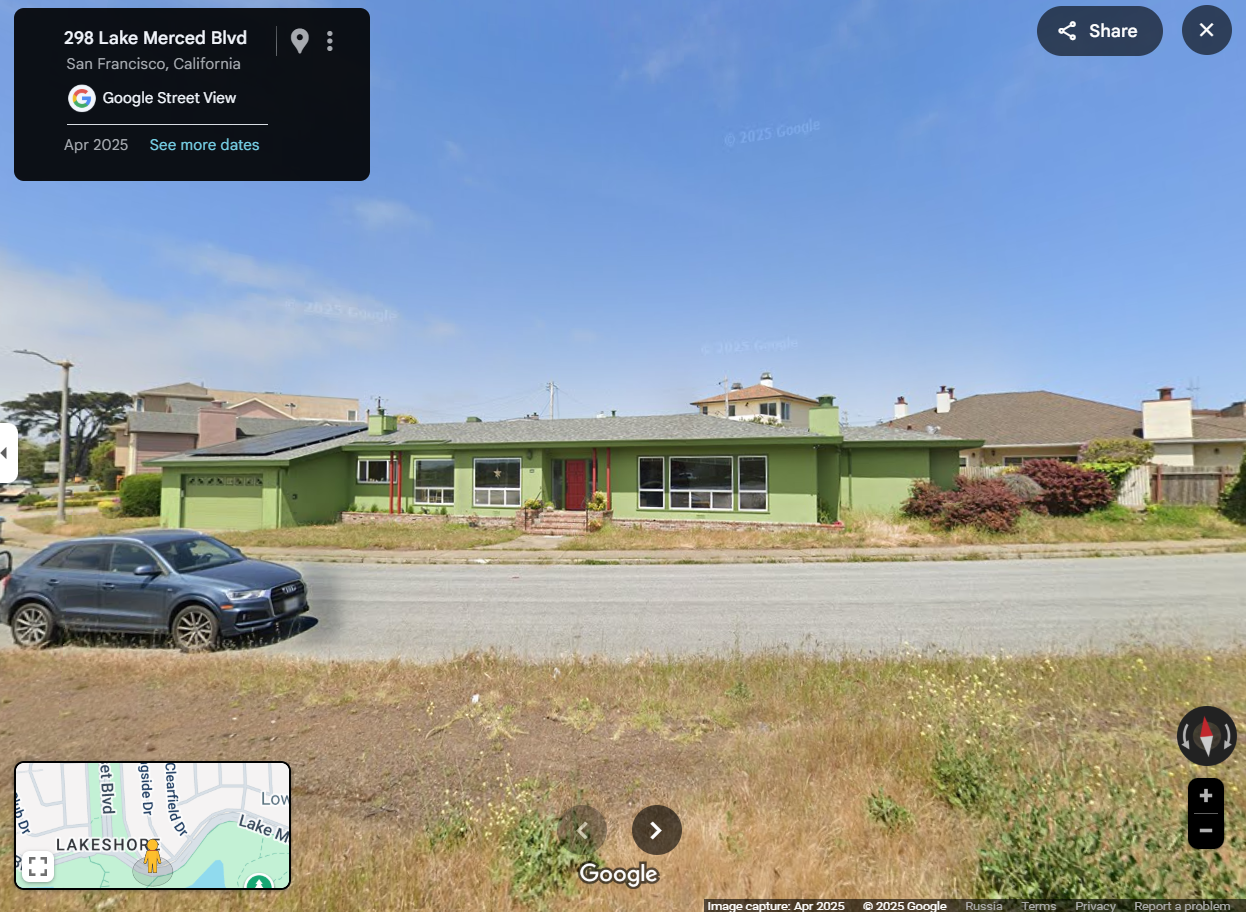

In [12]:
import pandas as pd

my_line = pd.DataFrame(columns=fetch_california_housing().feature_names, data=[[6, 30, 5, 3, 2, 4, 37.729269, -122.492121]])

lr_pred = lr.predict(my_line)[0]
ridge_pred = ridge.predict(my_line)[0]
lasso_pred = lasso.predict(my_line)[0]
elnet_pred = elnet.predict(my_line)[0]

print(f'lr: {round(lr_pred * 100000)}$')
print(f'ridge: {round(ridge_pred * 100000)}$')
print(f'lasso: {round(lasso_pred * 100000)}$')
print(f'elnet: {round(elnet_pred * 100000)}$')

lr: 459110$
ridge: 456597$
lasso: 424144$
elnet: 428483$


d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
d:\PythonWork\OldZmiy\NLPWork\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


## Графики остатков

In [13]:
def draw_res_graph(y_true, y_pred, name):
    resids = y_true - y_pred

    plt.scatter(y_true, resids)
    plt.axline((0, 0), (1, 0), color='black', linestyle='dashed')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title(f'График остатков {name}')
    plt.show()

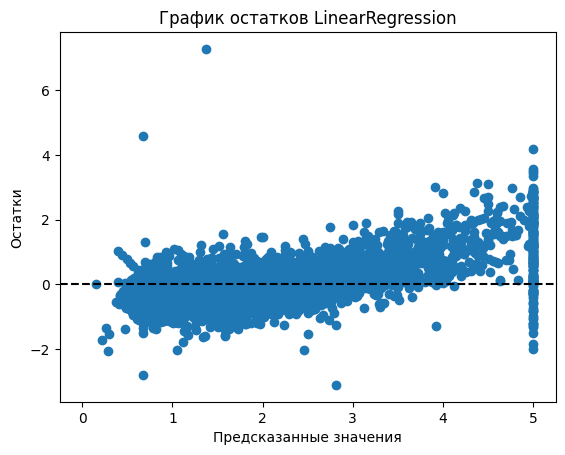

In [14]:
y_pr = lr.predict(X_test)
draw_res_graph(y_test, y_pr, 'LinearRegression')

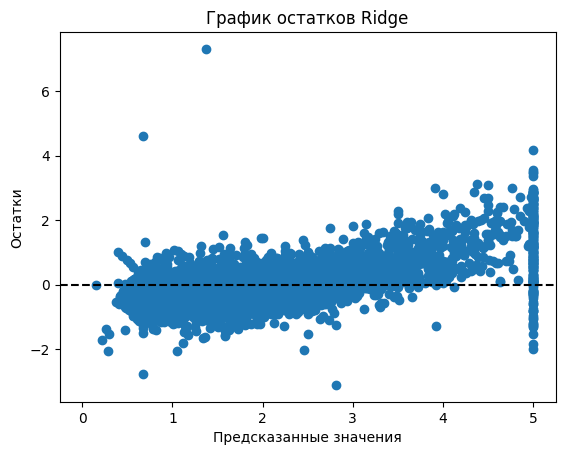

In [15]:
y_pr = ridge.predict(X_test)
draw_res_graph(y_test, y_pr, 'Ridge')

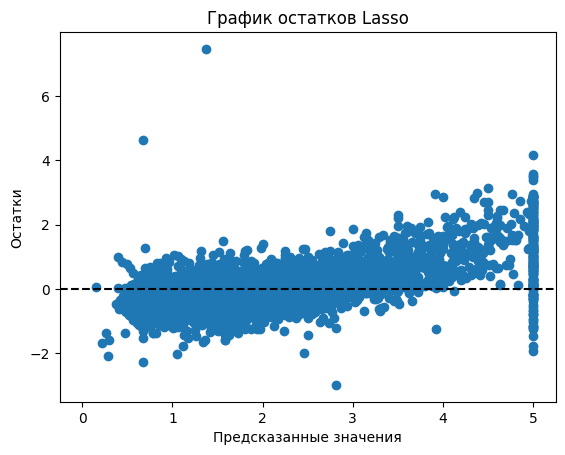

In [16]:
y_pr = lasso.predict(X_test)
draw_res_graph(y_test, y_pr, 'Lasso')

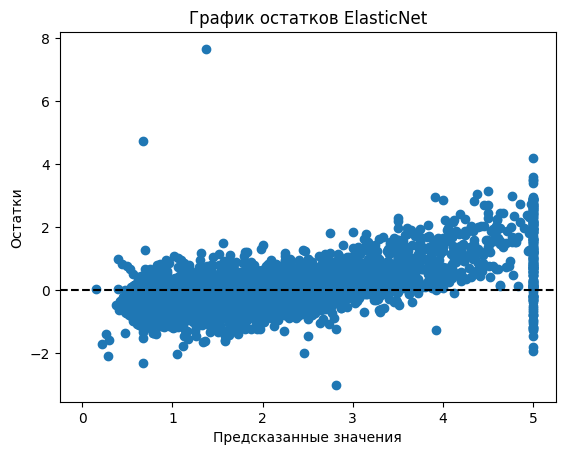

In [17]:
y_pr = elnet.predict(X_test)
draw_res_graph(y_test, y_pr, 'ElasticNet')

## Графики Predicted vs Actual

In [18]:
def draw_pvsa_graph(y_true, y_pred, name):
    plt.scatter(y_pred, y_true)
    plt.axline((0, 0), (1, 1), color='black', linestyle='dashed')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title(f'Predicted vs Actual {name}')
    plt.show()

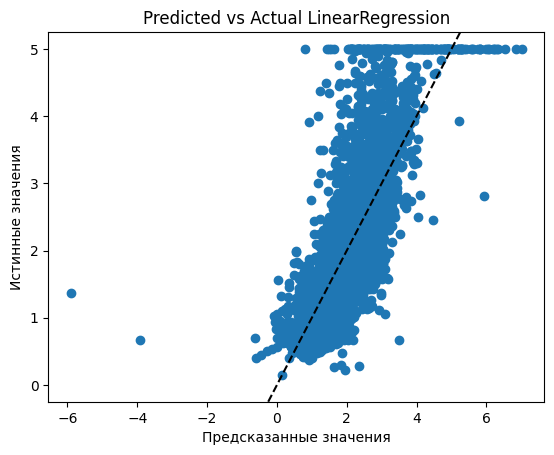

In [19]:
y_pr = lr.predict(X_test)
draw_pvsa_graph(y_test, y_pr, 'LinearRegression')

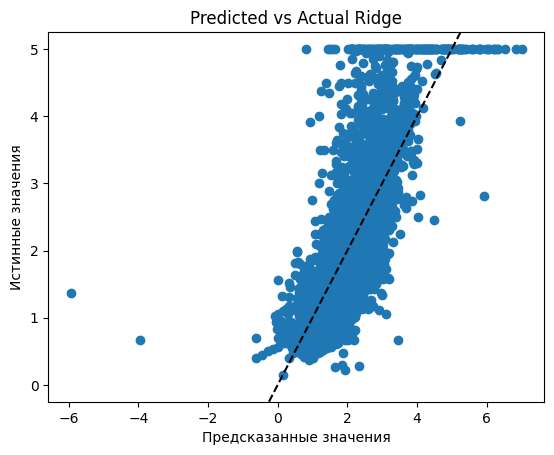

In [20]:
y_pr = ridge.predict(X_test)
draw_pvsa_graph(y_test, y_pr, 'Ridge')

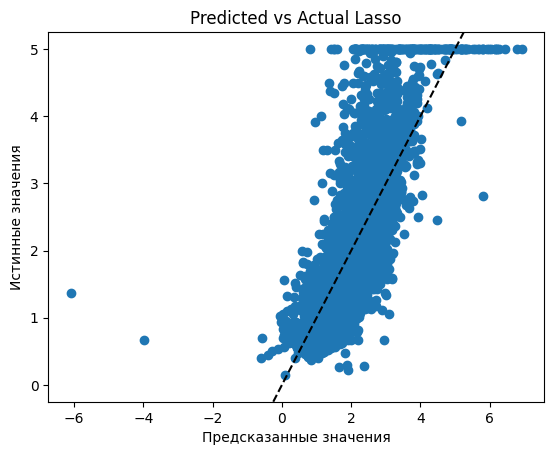

In [21]:
y_pr = lasso.predict(X_test)
draw_pvsa_graph(y_test, y_pr, 'Lasso')

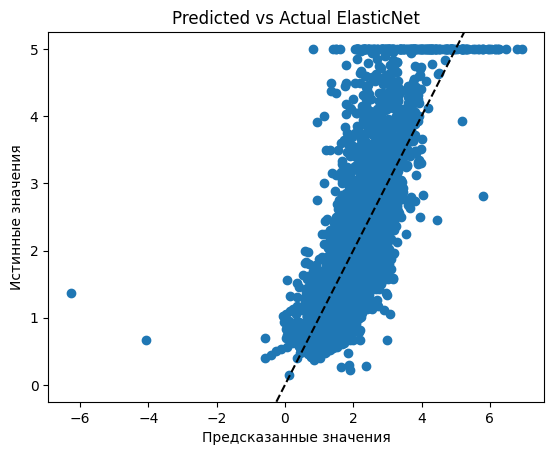

In [22]:
y_pr = elnet.predict(X_test)
draw_pvsa_graph(y_test, y_pr, 'ElasticNet')

### Недочеты

* Использовать также MAPE
* Рассмотреть графики рассеяния с другими признаками